In [11]:
#!pip install datasets transformers

import datasets
import numpy as np
from tqdm.notebook import tqdm_notebook
import torch
import math
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet50_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Pad, ConvertImageDtype, Lambda, RandomCrop
import matplotlib.pyplot as plt
from PIL import Image

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.min_model = None

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.min_model = model
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [12]:
################################# define dataset streaminig #################################
train_dataset = datasets.load_dataset("Hanneseh/custom_image_classifier_data", split="train", streaming=True)
val_dataset = datasets.load_dataset("Hanneseh/custom_image_classifier_data", split="validation", streaming=True)
test_dataset = datasets.load_dataset("Hanneseh/custom_image_classifier_data", split="test", streaming=True)


def count_samples(dataset):
    count = 0
    for _ in tqdm_notebook(dataset):
        count += 1
    return count

# train_dataset_size = count_samples(train_dataset)
train_dataset_size = 13
print("train_dataset size: {}".format(train_dataset_size))
# val_dataset_size = count_samples(val_dataset)
val_dataset_size = 3
print("val_dataset size: {}".format(val_dataset_size))
# test_dataset_size = count_samples(test_dataset)
test_dataset_size = 2
print("test_dataset size: {}".format(test_dataset_size))

train_dataset size: 13
val_dataset size: 3


In [13]:
################################# define the model and parameters #################################

# Set hyperparameters for training
num_epochs = 1
batch_size = 3
learning_rate = 0.001
patience = 5

def collate_fn(examples):
    images, labels = [], []

    image_transform = Compose([
        # apply random square crop with max possible size of the current image, then resize to 375x375
        RandomCrop(375, pad_if_needed=True),
        Resize((375,375)),
        ToTensor(),
        ])

    # Iterate through the examples, apply the image transformation, and append the results
    for example in examples:
        image = image_transform(example['image'])
        label = example['label']
        images.append(image)
        labels.append(label)

        pixel_values = torch.stack(images)
    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}


train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=batch_size)

# load and modify the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
stopper = EarlyStopper(patience=patience, min_delta=0)

In [14]:
################################# train the model #################################
tr = model.train()

train_accu = []
train_losses = []

eval_losses=[]
eval_accu=[]

def train(epoch, data):
    print('\nEpoch : %d' % epoch)
    model.train()
    correct = 0
    running_loss = 0
    total = 0
    for batch in tqdm_notebook(data):
        # Move input and label tensors to the device
        inputs = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / train_dataset_size
    accu = 100. * correct / total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f' % (train_loss, accu))

def val(data):
    model.eval()
    correct = 0
    running_loss = 0
    total = 0
    with torch.no_grad():
        for batch in data:
            # Move input and label tensors to the device
            inputs = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / val_dataset_size
    accu = 100. * correct / total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f' % (val_loss, accu))
    return val_loss


for epoch in range(1, num_epochs + 1):
    train(epoch, train_dataloader)
    val_loss = val(val_dataloader)
    PATH = './resnet50_hannes_v2_{}.pth'.format(epoch)
    torch.save(model.state_dict(), PATH)
    if stopper.early_stop(val_loss, model):
        model = stopper.min_model
        break


Epoch : 1


0it [00:00, ?it/s]

Train Loss: 0.348 | Accuracy: 30.769
Val Loss: 0.226 | Accuracy: 66.667


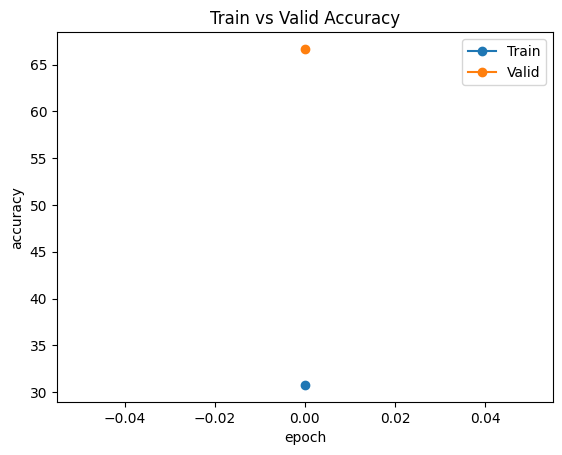

In [15]:
################################# plot trainin stats #################################

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

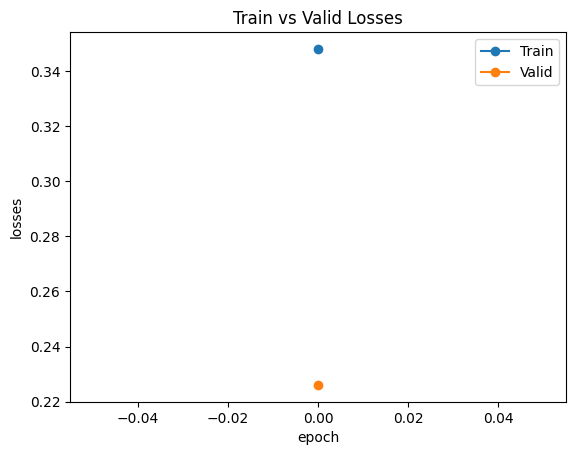

In [16]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [20]:
################################# test the model #################################
# Create a test dataloader
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

def test(data):
    correct = 0
    total = 0
    test_loss = 0
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        for element in tqdm_notebook(data):
            # Move input and label tensors to the device
            inputs = element["pixel_values"].to(device)
            labels = element["label"].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= test_dataset_size
    accuracy = 100. * correct / total
    print('Test Loss: %.3f | Accuracy: %.3f' % (test_loss, accuracy))

# Test the model on the test set
test(test_dataloader)

test_dataset size: 2


0it [00:00, ?it/s]

Test Loss: 0.341 | Accuracy: 50.000


0it [00:00, ?it/s]

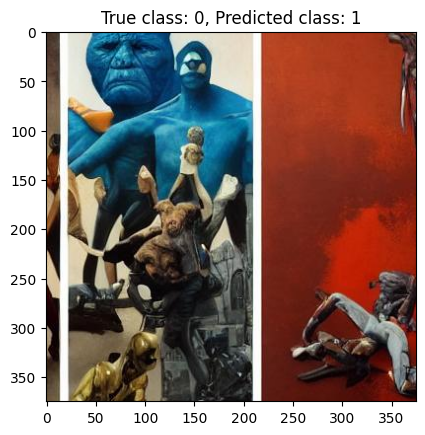

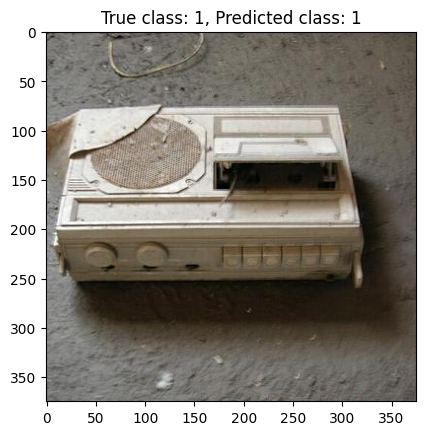

Test Loss: 0.346 | Accuracy: 50.000


In [21]:
def test(data):
    correct = 0
    total = 0
    test_loss = 0
    model.eval()  # Set the model to evaluation mode
    
    num_images_per_class = {0: 0, 1: 0}
    
    with torch.no_grad():
        for element in tqdm_notebook(data):
            # Move input and label tensors to the device
            inputs = element["pixel_values"].to(device)
            labels = element["label"].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Visualize images
            for i in range(inputs.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                
                if num_images_per_class[label] < 10:
                    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                    plt.imshow(img)
                    plt.title(f"True class: {label}, Predicted class: {pred}")
                    plt.show()
                    num_images_per_class[label] += 1

    test_loss /= test_dataset_size
    accuracy = 100. * correct / total
    print('Test Loss: %.3f | Accuracy: %.3f' % (test_loss, accuracy))

# Test the model on the test set
test(test_dataloader)

In [22]:
####################### check percentage of correct predictions per class #######################

classes = (0, 1)

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in test_dataloader:
        inputs = data["pixel_values"].to(device)
        labels = data["label"].to(device)
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: ',classname, "is " f'{accuracy:.1f} %')

Accuracy for class:  0 is 0.0 %
Accuracy for class:  1 is 100.0 %


In [24]:
################### predict single images ###################

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize, Pad, ConvertImageDtype, Lambda
import torch
import torchvision
from torchvision.models.resnet import ResNet50_Weights
import math
import datasets
import numpy as np
from tqdm.notebook import tqdm_notebook
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torch.nn.functional import softmax


In [ ]:
image_folder = '/Users/hannesehringfeld/ssd/Uni/DL_praktikum/MPDL_Project_1/images'
# model_path = "/Users/hannesehringfeld/ssd/Uni/DL_praktikum/MPDL_Project_1/models/resnet50_hannes_v1_16.pth"

# # load model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model = model.to(device)
# num_classes = 2
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

image_transform = Compose([
    # apply random square crop with max possible size of the current image, then resize to 375x375
    RandomCrop(375, pad_if_needed=True),
    Resize((375,375)),
    ToTensor(),
    ])

# Function to predict a single image
def predict_image(image_path):
    image = Image.open(image_path)
    img_tensor = image_transform(image)
    inputs = img_tensor.to(device)

    with torch.no_grad():
        outputs = model(inputs.unsqueeze(0))
        confidences = softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

    confidence_score = confidences[0][predicted.item()].item()
    plt.imshow(image)
    plt.title(f"Prediction: {predicted.item()} | Confidence: {confidence_score:.4f}, | True class: {image_path.split('/')[-1].split('_')[0]}")
    plt.show()

# Iterate through all images in the folder and make predictions
for image_file in os.listdir(image_folder):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_folder, image_file)
        predict_image(image_path)

In [ ]:
def print_logits_and_confidences(image_path):
    image = Image.open(image_path)
    img_tensor = image_transform(image)
    inputs = img_tensor.to(device)

    with torch.no_grad():
        outputs = model(inputs.unsqueeze(0))
        confidences = softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

    logits = outputs.cpu().numpy().flatten()
    confidences = confidences.cpu().numpy().flatten()

    print(f"Logits: {logits}")
    print(f"Confidences: {confidences}")


# Test on a few new images
for image_file in os.listdir(image_folder)[:5]:
    if image_file.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_folder, image_file)
        print_logits_and_confidences(image_path)